In [1]:
from collections import defaultdict
import warnings
from sys import stderr

import np
from jupyter_server.log import log_request
from lightning.pytorch.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import stock_indicators as sa
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import pandas as pd
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss
import yfinance as yf
from stock_indicators import Quote
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import norm
warnings.filterwarnings("ignore")
from cvxopt import matrix, solvers

C:\Users\valky\DataspellProjects\HF_Thesis\venv\Lib\site-packages\pytorch_forecasting\models\base_model.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
funds_w_names = defaultdict(pd.DataFrame)

In [3]:
etf_names = ['IE0005042456', 'EDMU.SW', 'EDG2.L', '36BA.DE', 'CBUS.DE', 'EWSA.AS','IE00B0M62X26','IE00B14X4Q57','IE00B1XNHC34','IE00B3FH7618','IE00B3ZW0K18','IE00B52MJY50','IE00B52VJ196','IE00B5M4WH52','IE00B66F4759','IE00B9M6RS56','IE00BD8PGZ49','IE00BDFK1573','IE00BDZVH966','IE00BFNM3G45','IE00BHZPJ015','IE00BHZPJ452','IE00BHZPJ783',
'IE00BLDGH553','IE00BMDFDY08','IE00BMG6Z448','IE00BYYHSM20','IE00BYZTVT56','IE00BZ173V67','IE00BZ1NCS44','ISVIF']

In [4]:
print(etf_names)

['IE0005042456', 'EDMU.SW', 'EDG2.L', '36BA.DE', 'CBUS.DE', 'EWSA.AS', 'IE00B0M62X26', 'IE00B14X4Q57', 'IE00B1XNHC34', 'IE00B3FH7618', 'IE00B3ZW0K18', 'IE00B52MJY50', 'IE00B52VJ196', 'IE00B5M4WH52', 'IE00B66F4759', 'IE00B9M6RS56', 'IE00BD8PGZ49', 'IE00BDFK1573', 'IE00BDZVH966', 'IE00BFNM3G45', 'IE00BHZPJ015', 'IE00BHZPJ452', 'IE00BHZPJ783', 'IE00BLDGH553', 'IE00BMDFDY08', 'IE00BMG6Z448', 'IE00BYYHSM20', 'IE00BYZTVT56', 'IE00BZ173V67', 'IE00BZ1NCS44', 'ISVIF']


In [16]:
for fund in etf_names:
    a = (pd.DataFrame(yf.Ticker(fund).history(start="2023-01-01", end="2024-01-01")))
    a.index = pd.to_datetime(a.index)
    a.index = a.index.normalize()
    full_date_range = pd.date_range(start=a.index.min(), end=a.index.max(), freq="D")
    a = a.reindex(full_date_range)
    a.fillna(method="bfill", inplace=True)
    if fund != 'ISVIF':
        a.drop(["Dividends", "Stock Splits", "Capital Gains"], inplace=True, axis=1)
    else:
        a.drop(["Dividends", "Stock Splits"], inplace=True, axis=1)
    funds_w_names[fund] = a

In [17]:
def portfolio_factory(etfs: list):
    giga_fund = pd.DataFrame()
    c = 0
    for f in etfs:
        f.index = pd.to_datetime(f.index)  # ensure index is datetime if not already
        f["time_idx"] = (f.index.date - f.index.date[0]).astype("timedelta64[D]").astype(int)
        f['group_id'] = c
        
        giga_fund = pd.concat([giga_fund, f])
        c+= 1
    return giga_fund

In [44]:
def technical_indicators_factory(etfs: list, names: list):
    indicators_per_fund = defaultdict(pd.DataFrame)
    figs = []

    for id, f in enumerate(etfs):
        quotes_for_f = [
            Quote(
                date=row.Index,
                open=row.Open,
                high=row.High,
                low=row.Low,
                close=row.Close,
                volume=row.Volume
            )
            for row in IE.itertuples()]

        ema_for_f = sa.indicators.get_ema(quotes_for_f, 9)
        valid_ema_for_f = [
            (result.date, result.ema)
            for result in ema_for_f
            if result.ema is not None
        ]
        ema_dates, ema_values = zip(*valid_ema_for_f)

        vwma_for_f = sa.indicators.get_vwma(quotes=quotes_for_f, lookback_periods=20)
        valid_vwma_for_f = [
            (result.date, result.vwma)
            for result in vwma_for_f
            if result.vwma is not None
        ]
        vwma_dates, vwma_values = zip(*valid_vwma_for_f)

        macd_for_f = sa.indicators.get_macd(quotes=quotes_for_f)
        valid_macd_for_f = [
            (result.date, result.macd, result.signal, result.histogram)
            for result in macd_for_f
            if result.macd is not None and result.signal is not None and result.histogram is not None
        ]
        macd_dates, macd_values, macd_signal, macd_histogram = zip(*valid_macd_for_f)

        stoch_for_f = sa.indicators.get_stoch(quotes=quotes_for_f)
        valid_stoch_for_f = [
            (result.date, result.oscillator, result.signal, result.percent_j)
            for result in stoch_for_f
            if result.date is not None and result.oscillator is not None and result.signal is not None
        ]
        stoch_dates, stoch_oscillator, stoch_signal, stoch_percent_j  = zip(*valid_stoch_for_f)

        fig, axes = plt.subplots(4, 1, figsize=(12,6))
        axes[0].plot(ema_dates[-20:], ema_values[-20:], label='EMA', linewidth=2)
        axes[0].plot(ema_dates[-20:], f['Close'][-20:], label='Close', linewidth=2)
        axes[0].legend(loc='best')

        axes[1].plot(vwma_dates[-20:], vwma_values[-20:], label='VWMA', linewidth=2)
        axes[1].plot(vwma_dates[-20:], f['Close'][-20:], label='Close', linewidth=2)
        axes[1].legend(loc='best')

        axes[2].plot(macd_dates[-20:], macd_values[-20:], label='MACD', linewidth=2)
        axes[2].plot(macd_dates[-20:], macd_signal[-20:], label='Signal', linewidth=2)
        axes[2].legend(loc='best')

        axes[3].plot(stoch_dates[-20:], stoch_oscillator[-20:], label='STOCH OSCILLATOR', linewidth=2)
        axes[3].plot(stoch_dates[-20:], stoch_percent_j[-20:], label='%J', linewidth=2)
        axes[3].plot(stoch_dates[-20:], stoch_signal[-20:], label='Signal', linewidth=2)
        axes[3].legend(loc='best')

        f['EMA'] = [x.ema for x in ema_for_f]
        f['MACD'] = [x.macd for x in macd_for_f]
        f['VWMA'] = [x.vwma for x in vwma_for_f]
        f['STOCH_OSCILLATOR'] = [x.oscillator for x in stoch_for_f]
        figs.append(fig)

        indicators_per_fund[names[id]]= f
    return indicators_per_fund, figs

In [40]:
def fit_predict(training_cutoff_idx: pd.Timestamp, epochs: int, batch_size: int, lr: float, dropout: float, df: pd.DataFrame, independent_variables: list):
    training = TimeSeriesDataSet(
        df[lambda x: x.time_idx <= training_cutoff_idx],  # Use the determined cutoff index
        time_idx="time_idx",                             # Sequential time index
        target="Close",                                  # Target variable
        group_ids=["group_id"],                          # Group identifier
        min_encoder_length=365 // 2,      # Minimum input sequence length
        max_encoder_length=365,           # Maximum input sequence length
        min_prediction_length=1,                         # Minimum forecast length
        max_prediction_length=7,     # Maximum forecast length (31 for December)
        static_reals=[],                                 # No static real variables
        time_varying_known_reals= independent_variables,  # Known inputs
        time_varying_unknown_reals=["Close"],            # Target variable
        target_normalizer=GroupNormalizer(groups=["group_id"], transformation="softplus"),
        add_relative_time_idx=True,                      # Add relative time index
        add_target_scales=True,                               # Scale the target variable
        add_encoder_length=True,                          # Include encoder length feature
        allow_missing_timesteps=False,                   # Ensure no missing steps
    )

    validation = TimeSeriesDataSet.from_dataset(
        training,
        df,
        predict=True,
        stop_randomization=True                             # Ensures no randomization in validation dataset
    )

    batch_size = batch_size

    train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
    val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

    tft = TemporalFusionTransformer.from_dataset(
        training,
        learning_rate=lr,              # Learning rate
        hidden_size=16,                  # Model hidden size
        attention_head_size=1,           # Number of attention heads
        dropout=dropout,                     # Dropout rate
        hidden_continuous_size=8,        # Hidden size for continuous variables
        output_size=7,                   # Output quantiles (e.g., 10th to 90th percentile)
        loss=QuantileLoss(),             # Loss function
        log_interval=10,                 # Log every 10 batches
        reduce_on_plateau_patience=4,    # Reduce learning rate on plateau
    )

    checkpoint_callback = ModelCheckpoint(
        dirpath="checkpoints/",
        filename="tft-model-{epoch:02d}-{val_loss:.2f}",
        save_top_k=1,
        monitor="val_loss",  # 
        mode="min",  # minimize validation loss
    )

    early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=4, verbose=False, mode="min")
    lr_logger = LearningRateMonitor()  # log the learning rate
    logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

    trainer = pl.Trainer(
        # logger=logger,
        max_epochs=epochs,
        accelerator='cuda',
        devices="auto",
        gradient_clip_val=0.1,
        callbacks=[early_stop_callback, lr_logger, checkpoint_callback],
    )

    trainer.fit(tft, train_dataloader, val_dataloader)
    raw_predictions = tft.predict(val_dataloader, mode="raw", return_x=True)
    predicted_median_np = raw_predictions.output.prediction[0, :, 1].detach().cpu().numpy()
    return predicted_median_np

In [20]:
def metrics_and_plt(df: pd.DataFrame, preds:list, date_range:pd.date_range):
    actual_values = df["Close"]["2023-12-23":]
    mse = mean_squared_error(actual_values, preds)

    plt.figure(figsize=(10, 6))
    plt.plot(date_range, actual_values, marker="x", label="Actual Close", color="orange")
    plt.plot(date_range, preds, marker="o", label="Predicted Median")
    plt.title("Predicted Values for December 23 to December 29, 2023")
    plt.xlabel("Date")
    plt.ylabel("Predicted Value")
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()
    return mse, plt

NO INDICATORS, ONE ETF

In [21]:
#IE00B52MJY50
IE = portfolio_factory(etfs=[funds_w_names['EWSA.AS']])

In [22]:
training_cutoff_date = pd.to_datetime("2023-12-22 00:00:00+01:00").tz_convert("Europe/London")
training_cutoff_idx = IE.loc[training_cutoff_date, "time_idx"]

In [23]:
IE_preds = fit_predict(training_cutoff_idx=training_cutoff_idx, epochs=100, batch_size=128, lr=1e-3, dropout=0.1, df=IE, independent_variables=["Open", "High", "Low", "Volume"])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers 

Epoch 0: 100%|██████████| 2/2 [00:00<00:00,  2.81it/s, v_num=31, train_loss_step=0.205]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 2/2 [00:00<00:00,  4.14it/s, v_num=31, train_loss_step=0.201, val_loss=0.395, train_loss_epoch=0.219]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 2/2 [00:00<00:00,  4.12it/s, v_num=31, train_loss_step=0.188, val_loss=0.371, train_loss_epoch=0.200]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 2/2 [00:00<00:00,  4.10it/s, v_num=31, train_loss_step=0.169, val_loss=0.350, train_loss_epoch=0.183]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 2/2 [00:00<00:00,  4.08it/s, v_num=31, train_loss_step=0.156, val_loss=0.328, train_loss_epoch=0.172]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 2/2 [00:00<00:00,  4.22it/s, v_num=31, train_loss_step=0.144, val_loss=0.304, train_loss_epoch=0.160]
Validation: |          | 0/? [00:00<?, ?it

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


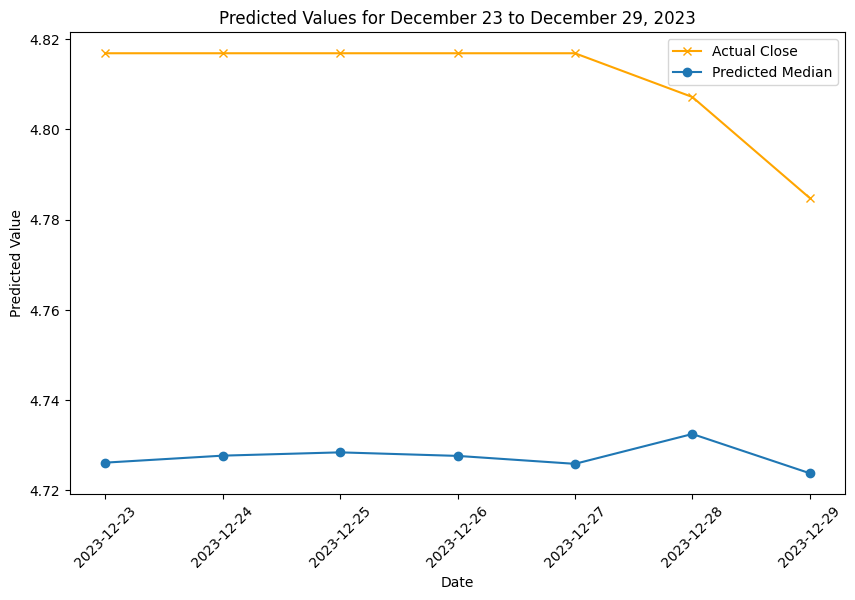

In [24]:
IE_mse, IE_plt = metrics_and_plt(IE, IE_preds, pd.date_range(start="2023-12-23", end="2023-12-29"))

In [26]:
IE_mse

0.007080298479390227

ADDING INDICATORS

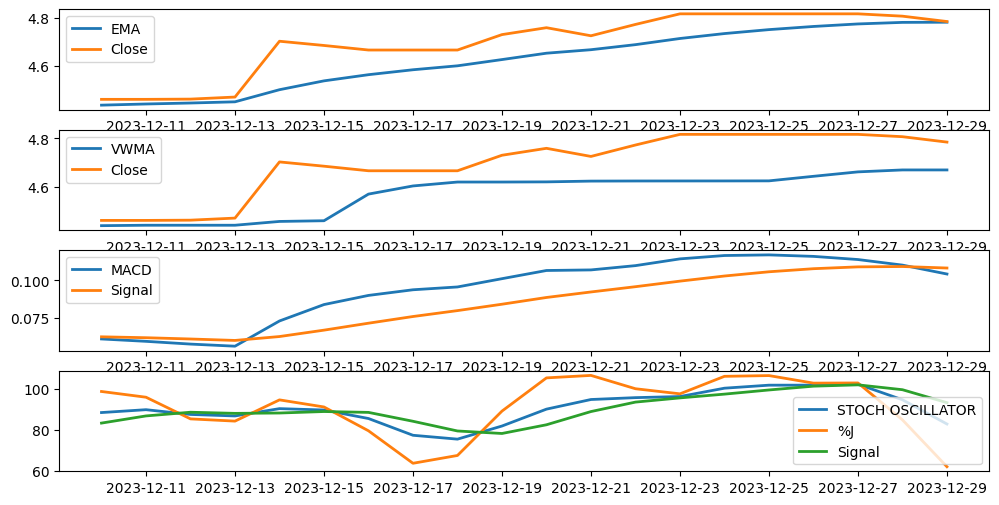

In [45]:
IE_indicators, IE_indicators_plt1 = technical_indicators_factory([funds_w_names['EWSA.AS']], ['EWSA.AS'])

In [46]:
IE_indicators

defaultdict(pandas.core.frame.DataFrame,
            {'EWSA.AS':                              Open    High     Low   Close  Volume  time_idx  \
             2023-01-02 00:00:00+01:00  4.2127  4.2127  4.2127  4.2127     0.0         0   
             2023-01-03 00:00:00+01:00  4.2018  4.2150  4.2018  4.2071    66.0         1   
             2023-01-04 00:00:00+01:00  4.1953  4.2243  4.1953  4.2243  1900.0         2   
             2023-01-05 00:00:00+01:00  4.2210  4.2210  4.2210  4.2210     0.0         3   
             2023-01-06 00:00:00+01:00  4.1905  4.1905  4.1905  4.1905     0.0         4   
             ...                           ...     ...     ...     ...     ...       ...   
             2023-12-25 00:00:00+01:00  4.8106  4.8106  4.8106  4.8169     0.0       357   
             2023-12-26 00:00:00+01:00  4.8106  4.8106  4.8106  4.8169     0.0       358   
             2023-12-27 00:00:00+01:00  4.8106  4.8106  4.8106  4.8169     0.0       359   
             2023-12-28 00:0

In [47]:
IE_preds = fit_predict(training_cutoff_idx=training_cutoff_idx, epochs=120, batch_size=128, lr=1e-4, dropout=0.1, df=IE_indicators["EWSA.AS"], independent_variables=["Open", "High", "Low", "Volume", "EMA", "VWMA", "MACD", "STOCH_OSCILLATOR"])

ValueError: 8 (2.25%) of EMA values were found to be NA or infinite (even after encoding). NA values are not allowed `allow_missing_timesteps` refers to missing rows, not to missing values. Possible strategies to fix the issue are (a) dropping the variable EMA, (b) using `NaNLabelEncoder(add_nan=True)` for categorical variables, (c) filling missing values and/or (d) optionally adding a variable indicating filled values

In [ ]:
IE_indicators_mse, IE_indicators_plt2= metrics_and_plt(IE_preds, pd.date_range(start="2023-12-23", end="2023-12-29"))

FULL HEDGE PORTFOLIO

In [ ]:
IE_indicators, IE_indicators_plt1 = technical_indicators_factory([funds_w_names['IE00B52MJY50']], ['IE00B52MJY50'])

In [ ]:
GIGAFUND, GIGAFUND_MIN_IND = portfolio_factory(etfs=funds_w_names.values())

In [4]:
def volatility_dataset_factory(funds):
    for k, v in funds.items():
        print(f"{k}:")
        funds[k]["Return"] = funds[k]["Close"].pct_change()
        funds[k]["Rolling Volatility"] = funds[k]["Return"].rolling(7).std()
        funds[k].fillna(method="bfill", inplace=True)


Monte Carlo

In [5]:
def calc_drift(funds):
    drift_dict={}
    for k, v in funds.items():
        log_returns = np.log(1+funds[k]["Close"].pct_change())
        log_returns.fillna(value=0, inplace=True)
        avg_pdr = log_returns.mean()
        var = log_returns.var()
        drift = avg_pdr-(.5*var)
        drift_dict[k]=drift
    return drift_dict

In [6]:
def monte_carlo_sim(funds, drifts):
    price_paths={}
    for k, v in funds.items():
        log_returns = np.log(1+funds[k]["Close"].pct_change())
        log_returns.fillna(value=0, inplace=True)
        stdev=log_returns.std()
        days=362
        trials=100
        Z = norm.ppf(np.random.rand(days,trials))
        daily_returns=np.exp(np.array(drifts[k]) + np.array(stdev) * Z)
        price_paths[k] = np.zeros_like(daily_returns)
        price_paths[k][0] = funds[k]["Close"].iloc[-1]
        for i in range(1,days):
            price_paths[k][i] = price_paths[k][i-1] * daily_returns[i-1]
    return price_paths

In [12]:
drifts=calc_drift(funds_w_names)
pp=monte_carlo_sim(funds_w_names, drifts=drifts)

[[ 1.54084013 -0.15792526  0.10855738 ... -0.80738228  0.26978628
  -0.86088422]
 [-0.92290093 -1.07397645 -0.33594253 ... -0.750178   -0.08731603
  -1.0868117 ]
 [ 0.6006401  -0.80559814  1.37625864 ... -0.93095024 -0.83512118
  -0.22065422]
 ...
 [ 0.60570525  0.14228556  0.04895696 ...  2.34686092  0.50409561
   0.63785363]
 [-1.0968285   1.40992006  0.77651015 ... -0.18436706  0.12357565
   0.96070576]
 [ 2.01302838 -0.87066056  0.71336991 ...  1.99891665 -1.02679074
  -1.4256653 ]]
[[ 1.03743399 -1.91789017 -1.04420091 ...  0.22543392  0.64696968
  -0.853349  ]
 [-0.49163274 -1.49670244 -0.86273064 ... -3.41976489 -1.56405469
   0.20043141]
 [ 1.86924009 -0.17006545 -0.1874016  ... -0.0901987   0.56500495
  -0.36794682]
 ...
 [-0.58199965  0.32243732 -0.11545701 ...  0.44109351  1.05575345
   0.96656683]
 [ 0.71774837 -2.23734959 -0.41921985 ...  1.62239195 -0.57286063
  -0.06242415]
 [-1.60088409 -0.82400782 -1.93818166 ... -1.51373656 -0.16494499
  -0.30813647]]
[[-0.48715356  2

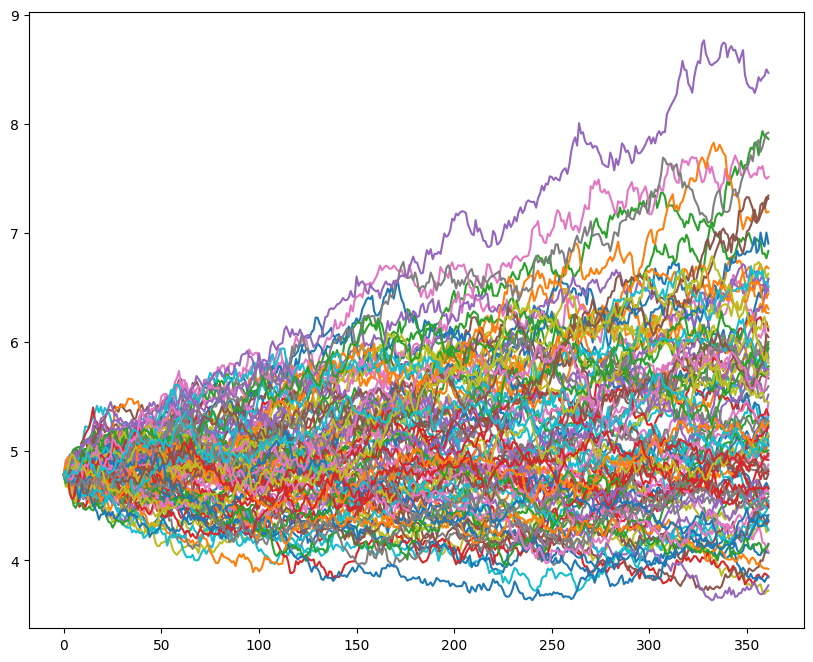

In [20]:
plt.figure(figsize=(10, 8))
plt.plot(pp["EWSA.AS"])

CHOLESKY MONTE CARLO

In [13]:
def nearest_positive_definite(matrix):
    m = matrix.shape[0]
    P = matrix.copy()
    eigvals, eigvecs = np.linalg.eigh(P)
    eigvals[eigvals < 0] = 1e-10 
    return eigvecs @ np.diag(eigvals) @ eigvecs.T

In [14]:
closes = {}
covs_means = []
for k,v in funds_w_names.items():
    closes[k] = v["Close"]
closes = pd.DataFrame(closes)
r = closes.pct_change()
covariance_matrix = r.cov()
mean_returns = r.mean()

In [17]:
if not np.all(np.linalg.eigvals(covariance_matrix) > 0): 
    print("Covariance matrix not positive definite. Adding regularization.")
    covariance_matrix = nearest_positive_definite(covariance_matrix)

In [16]:
covariance_matrix

array([[ 9.77477985e-06, -1.98032100e-07,  6.83130974e-06,
        -3.99151619e-09, -1.27801611e-09, -1.15847617e-08,
        -9.67085302e-10, -2.06033599e-09, -2.10338997e-09,
        -1.45772851e-09,  7.09899354e-06, -2.41772516e-09,
        -1.36389549e-09,  2.94373493e-06,  2.61791563e-06,
         2.17617700e-06, -7.25232343e-07, -7.87669121e-07,
        -7.20571711e-24,  7.20720125e-06, -7.94037941e-10,
         2.80567008e-09, -1.47652174e-09, -2.98264534e-09,
         1.32861313e-10, -4.08662360e-09, -1.85120964e-09,
         3.54580150e-07, -5.78104847e-09,  2.75522905e-06,
        -2.32598827e-11],
       [-1.98032100e-07,  1.16462826e-05, -1.55689070e-07,
         3.97108411e-06,  2.72039656e-06,  1.42171541e-05,
         2.17499057e-06,  3.84474251e-07,  2.00224866e-05,
         7.25108621e-08, -4.08530699e-07,  1.07232984e-05,
         4.54758623e-06, -2.80632612e-07, -1.72490608e-07,
        -3.53408927e-07, -5.53127695e-07, -5.49749833e-08,
        -1.34320368e-23, -4.49

In [18]:
#to be filled with real data
portfolio_weights = np.random.random(len(mean_returns)) # distribution of etfs in portfolio
portfolio_weights /= np.sum(portfolio_weights)

In [19]:
print(portfolio_weights)

[0.03480438 0.02675872 0.00686378 0.02759941 0.03730905 0.03651236
 0.05104064 0.02064885 0.04706747 0.00291022 0.01133678 0.04166641
 0.05814995 0.04544055 0.05546658 0.05605963 0.04166547 0.04826612
 0.03591984 0.0345171  0.0126599  0.0394766  0.0236752  0.01676623
 0.01999333 0.02993949 0.0274981  0.04779861 0.01607342 0.01169806
 0.03441779]


In [20]:
days = 60
simulations = 100
initial_port = 10000 # initial portfolio value
portfolio_sims = np.full(shape=(days, simulations), fill_value=0.0) # default
mean_matrix = np.full(shape=(days, len(portfolio_weights)), fill_value=mean_returns).T # days x all etfs

Text(0, 0.5, 'Portfolio Simulations')

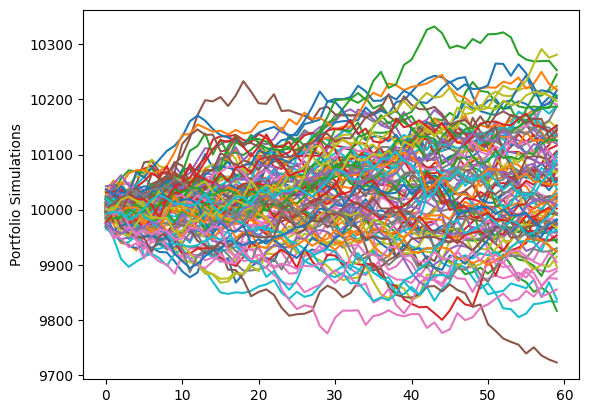

In [21]:
for s in range(0, simulations):
    Z = np.random.normal(size=(days, len(portfolio_weights)))
    L = np.linalg.cholesky(covariance_matrix)
    daily_returns = mean_matrix + np.inner(L, Z)
    portfolio_sims[:, s] = np.cumprod(np.inner(portfolio_weights, daily_returns.T)+1)*initial_port
        
plt.plot(portfolio_sims)
plt.ylabel("Portfolio Simulations")

ez

In [ ]:
discounted_prices = [sim[-1]*0.04 for sim in portfolio_sims]

In [ ]:
avg = np.average(discounted_prices)

bs

In [170]:
covariance_matrix

array([[ 9.77470879e-06, -1.63465813e-07,  6.83137194e-06,
        -3.17829663e-09, -8.92164164e-10, -8.71809703e-09,
        -8.35580033e-10, -1.60126691e-09, -3.77771779e-10,
        -1.15123477e-09,  7.09893229e-06, -2.00906855e-09,
        -1.74732475e-09,  2.94372666e-06,  2.61780954e-06,
         2.17613208e-06, -7.25304940e-07, -7.87704521e-07,
         7.25536063e-25,  7.20709614e-06, -1.28538941e-09,
         1.10153280e-09, -1.73506780e-09, -2.23194080e-09,
        -3.84643478e-10, -3.97144358e-09, -2.09364442e-09,
         3.54447958e-07, -5.08681113e-09,  2.75524148e-06,
        -1.74048602e-10],
       [-1.63465813e-07,  1.16438103e-05, -1.43471710e-07,
         3.94054918e-06,  2.74646799e-06,  1.42176847e-05,
         2.18652031e-06,  3.83242444e-07,  2.00337436e-05,
         7.21416816e-08, -3.68977424e-07,  1.07353149e-05,
         4.53674926e-06, -2.78065953e-07, -1.64266462e-07,
        -3.58255951e-07, -5.78038844e-07, -6.05260788e-08,
        -1.10806206e-22, -4.09